In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import glob
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

2025-02-03 18:33:44.950081: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
WINDOW_LENGTH = 256  # data window
STRIDE = 128        # stride
BATCH_SIZE = 64  # batch
EPOCHS = 100  # epoch
LEARNING_RATE = 0.0001  # lr
PROJ_DIM = 128  # embedding dimension

In [3]:
datapath = "../../../data/SisFall_Dataset/" 

In [4]:
'''
        Each file contains nine columns and a different number of rows depending on the test length.
        
        1st column is the acceleration data in the X axis measured by the sensor ADXL345.
        2nd column is the acceleration data in the Y axis measured by the sensor ADXL345.
        3rd column is the acceleration data in the Z axis measured by the sensor ADXL345.

        4th column is the rotation data in the X axis measured by the sensor ITG3200.
        5th column is the rotation data in the Y axis measured by the sensor ITG3200.
        6th column is the rotation data in the Z axis measured by the sensor ITG3200.

        7th column is the acceleration data in the X axis measured by the sensor MMA8451Q.
        8th column is the acceleration data in the Y axis measured by the sensor MMA8451Q.
        9th column is the acceleration data in the Z axis measured by the sensor MMA8451Q.
        
        Data are in bits with the following characteristics:

        ADXL345:
        Resolution: 13 bits
        Range: +-16g

        ITG3200
        Resolution: 16 bits
        Range: +-2000°/s

        MMA8451Q:
        Resolution: 14 bits
        Range: +-8g
'''

'\n        Each file contains nine columns and a different number of rows depending on the test length.\n        \n        1st column is the acceleration data in the X axis measured by the sensor ADXL345.\n        2nd column is the acceleration data in the Y axis measured by the sensor ADXL345.\n        3rd column is the acceleration data in the Z axis measured by the sensor ADXL345.\n\n        4th column is the rotation data in the X axis measured by the sensor ITG3200.\n        5th column is the rotation data in the Y axis measured by the sensor ITG3200.\n        6th column is the rotation data in the Z axis measured by the sensor ITG3200.\n\n        7th column is the acceleration data in the X axis measured by the sensor MMA8451Q.\n        8th column is the acceleration data in the Y axis measured by the sensor MMA8451Q.\n        9th column is the acceleration data in the Z axis measured by the sensor MMA8451Q.\n        \n        Data are in bits with the following characteristics:\

In [5]:
adl_activities = [f'D{str(i).zfill(2)}' for i in range(1, 20)]  # D01-D19
fall_activities = [f'F{str(i).zfill(2)}' for i in range(1, 16)]  # F01-F15

label2id = {act: 0 for act in adl_activities}
label2id.update({act: 1 for act in fall_activities})

adult_subjects = [f'SA{str(i).zfill(2)}' for i in range(1, 24)]  # SA01-SA23
elderly_subjects = [f'SE{str(i).zfill(2)}' for i in range(1, 16)]  # SE01-SE15

train_sa = adult_subjects[:16]    # 16 subjects
val_sa = adult_subjects[16:19]    # 3 subjects
test_sa = adult_subjects[19:]     # 4 subjects

train_se = elderly_subjects[:10]  # 10 subjects
val_se = elderly_subjects[10:12]  # 2 subjects
test_se = elderly_subjects[12:]   # 3 subjects

train_split = train_sa + train_se
val_split = val_sa + val_se
test_split = test_sa + test_se

all_subjects = adult_subjects + elderly_subjects  # all subjects

In [6]:
def read_sensor_file(filepath) :
   """
       first 6 columns : ADXL345 acc + ITG3200 gyro
   """
   with open(filepath, 'r') as file:
       content = file.read()

   content = content.replace(' ', '')  # delete blank
   rows = []

   for line in content.split(';\n'): 
       if line.strip():
           try:
               values = [float(x) for x in line.split(',')[:6]]
               rows.append(values)
           except (ValueError, IndexError):
               continue

   return np.array(rows)

In [7]:
def split_sequences(data, labels, 
                    window_length=WINDOW_LENGTH, 
                    stride=STRIDE,
                    clean=True):
    idx = 0
    endidx = len(data)
    windows = []
    window_labels = []
    
    while idx < endidx - window_length:
        data_segment = data[idx:idx+window_length].T
        
        if clean and len(np.unique(labels[idx:idx + window_length])) > 1:
            pass
        else:
            windows.append(data_segment)
            window_labels.append(labels[idx+window_length])
        
        idx += stride
    
    if len(windows) == 0:
        return None, None
    
    return np.stack(windows), np.asarray(window_labels)

In [8]:
'''
   TRAIN DATA PREPARING PART
   ONLY "ADL"
'''
train_data_normal = []  
train_labels_normal = [] 

# for subject in tqdm(train_split):  
for subject in tqdm(all_subjects, desc="Processing training data (ADL)"):
   subject_dir = os.path.join(datapath, subject)
   
   if subject.startswith('SE') and subject != 'SE06':
       continue
       
   for activity in adl_activities:
       activity_pattern = os.path.join(subject_dir, f"{activity}*.txt")
       activity_files = glob.glob(activity_pattern)
       
       for file_path in activity_files:
           try:
               raw_data = read_sensor_file(file_path)
               if raw_data is not None and raw_data.shape[1] == 6:
                   sensor_data = raw_data
                   activity_labels = np.full(len(sensor_data), label2id[activity])
                   
                   windows_data, windows_labels = split_sequences(
                       sensor_data, activity_labels, 
                       WINDOW_LENGTH, STRIDE
                   )
                   
                   if windows_data is not None and len(windows_data) > 0:
                       train_data_normal.append(windows_data)
                       train_labels_normal.append(windows_labels)
                   
           except Exception as e: 
               print(f"Error processing file {file_path}: {e}")
               
train_data_normal = np.concatenate(train_data_normal, axis=0)
train_labels_normal = np.concatenate(train_labels_normal)

print (f"# of windows: {len(train_data_normal)}")
print (f"data shape: {train_data_normal.shape}")
print (f"labels shape: {train_labels_normal.shape}")
unique_labels, counts = np.unique(train_labels_normal, return_counts=True)
print (dict(zip(unique_labels, counts)))

Processing training data (ADL): 100%|███████████| 38/38 [00:19<00:00,  1.94it/s]


# of windows: 52925
data shape: (52925, 6, 256)
labels shape: (52925,)
{0: 52925}


In [9]:
'''
   TEST DATA PREPARING PART
   ADL + FALL
'''
test_data = []
test_labels = []

# for subject in tqdm(test_split):
for subject in tqdm(all_subjects, desc="Processing test data (ADL + FALL)"):
   subject_dir = os.path.join(datapath, subject)
   
   is_elderly = subject.startswith('SE')
   
   if not (is_elderly and subject != 'SE06'): 
       for activity in adl_activities:
           activity_pattern = os.path.join(subject_dir, f"{activity}*.txt")
           activity_files = glob.glob(activity_pattern)
           
           for file_path in activity_files:
               try:
                   raw_data = read_sensor_file(file_path)
                   if raw_data is not None and raw_data.shape[1] == 6:
                       sensor_data = raw_data
                       activity_labels = np.full(len(sensor_data), label2id[activity])
                       
                       windows_data, windows_labels = split_sequences(
                           sensor_data, activity_labels,
                           WINDOW_LENGTH, STRIDE
                       )
                       
                       if windows_data is not None and len(windows_data) > 0:
                           test_data.append(windows_data)
                           test_labels.append(windows_labels)
                           
               except Exception as e:
                   print(f"Error processing file {file_path}: {e}")
   
   if not is_elderly or subject == 'SE06':
       for activity in fall_activities:
           activity_pattern = os.path.join(subject_dir, f"{activity}*.txt")
           activity_files = glob.glob(activity_pattern)
           
           for file_path in activity_files:
               try:
                   raw_data = read_sensor_file(file_path)
                   if raw_data is not None and raw_data.shape[1] == 6:
                       sensor_data = raw_data
                       activity_labels = np.full(len(sensor_data), label2id[activity])
                       
                       windows_data, windows_labels = split_sequences(
                           sensor_data, activity_labels,
                           WINDOW_LENGTH, STRIDE
                       )
                       
                       if windows_data is not None and len(windows_data) > 0:
                           test_data.append(windows_data)
                           test_labels.append(windows_labels)
                           
               except Exception as e:
                   print(f"Error processing file {file_path}: {e}")

test_data = np.concatenate(test_data, axis=0)
test_labels = np.concatenate(test_labels)

print (f"# of windows: {len(test_data)}")
print (f"data shape: {test_data.shape}")
print (f"labels shape: {test_labels.shape}")
unique_labels, counts = np.unique(test_labels, return_counts=True)
print(dict(zip(unique_labels, counts)))

Processing test data (ADL + FALL): 100%|████████| 38/38 [00:33<00:00,  1.12it/s]


# of windows: 92480
data shape: (92480, 6, 256)
labels shape: (92480,)
{0: 52925, 1: 39555}


In [10]:
train_data_shape = train_data_normal.shape
test_data_shape = test_data.shape

train_data_2d = train_data_normal.reshape(-1, train_data_normal.shape[-1])
test_data_2d = test_data.reshape(-1, test_data.shape[-1])

scaler = StandardScaler()
train_data_2d = scaler.fit_transform(train_data_2d)
test_data_2d = scaler.transform(test_data_2d)

train_data_normal = train_data_2d.reshape(train_data_shape)
test_data = test_data_2d.reshape(test_data_shape)

In [11]:
train_acc_normal = train_data_normal[..., :3] 
train_gyro_normal = train_data_normal[..., 3:]  
# (x, y, z)

test_acc = test_data[..., :3]  
test_gyro = test_data[..., 3:] 

train_dataset = tf.data.Dataset.from_tensor_slices((train_acc_normal, train_gyro_normal))
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(
    ((test_acc, test_gyro), test_labels)
).batch(BATCH_SIZE)

print (f"train data - accel shape: {train_acc_normal.shape}")
print (f"train data - gyro shape: {train_gyro_normal.shape}")
print (f"test data - accel shape: {test_acc.shape}")
print (f"test data - gyro shape: {test_gyro.shape}")
print (f"# of training batches: {len(train_dataset)}")
print (f"# of test batches: {len(test_dataset)}")

train data - accel shape: (52925, 6, 3)
train data - gyro shape: (52925, 6, 253)
test data - accel shape: (92480, 6, 3)
test data - gyro shape: (92480, 6, 253)
# of training batches: 827
# of test batches: 1445


------

In [12]:
class Encoder(Model):
    def __init__(self, in_feat, out_feat, num_encoders=1, use_skip=True):
        super(Encoder, self).__init__()
        self.use_skip = use_skip
        self.num_encoders = num_encoders
        
        for i in range(num_encoders):
            setattr(self, f'conv1_{i}', layers.Conv1D(filters=out_feat*3, 
                                                      kernel_size=7, padding='same', 
                                                      activation='relu'))
            setattr(self, f'maxpool1_{i}', layers.MaxPooling1D(pool_size=2, padding='same'))
            setattr(self, f'conv2_{i}', layers.Conv1D(filters=out_feat*2, 
                                                      kernel_size=5, padding='same', 
                                                      activation='relu'))
            setattr(self, f'maxpool2_{i}', layers.MaxPooling1D(pool_size=2, padding='same'))
            setattr(self, f'conv3_{i}', layers.Conv1D(filters=out_feat*1, 
                                                      kernel_size=3, padding='same', 
                                                      activation='relu'))
    
    def call(self, x, training=False):
        for i in range(self.num_encoders):
            if self.use_skip and i > 0:
                identity = x
            
            x = getattr(self, f'conv1_{i}')(x)
            x = getattr(self, f'maxpool1_{i}')(x)
            x = getattr(self, f'conv2_{i}')(x)
            x = getattr(self, f'maxpool2_{i}')(x)
            x = getattr(self, f'conv3_{i}')(x)
            
            if self.use_skip and i > 0:
                x = x + identity
        
        return tf.reduce_mean(x, axis=1)

In [13]:
class CAGE(Model):
    def __init__(self, n_feat=6, proj_dim=128):
        super(CAGE, self).__init__()
        self.proj_dim = proj_dim
        
        self.enc_A = Encoder(n_feat, 64)
        self.enc_G = Encoder(n_feat, 64)
        
        if self.proj_dim > 0:
            self.proj_A = layers.Dense(proj_dim, use_bias=False)
            self.proj_G = layers.Dense(proj_dim, use_bias=False)
        
#         self.temperature = tf.Variable(0.1, trainable=True)
        self.temperature = tf.constant(0.1)
    
    def call(self, x_accel, x_gyro, return_feat=False, training=False):
        f_accel = self.enc_A(x_accel, training=training)
        f_gyro = self.enc_G(x_gyro, training=training)
        
        if self.proj_dim > 0:
            e_accel = self.proj_A(f_accel)
            e_gyro = self.proj_G(f_gyro)
        else:
            e_accel = f_accel
            e_gyro = f_gyro
        
        e_accel = tf.math.l2_normalize(e_accel, axis=1)
        e_gyro = tf.math.l2_normalize(e_gyro, axis=1)
        
        sim_matrix = tf.matmul(e_accel, e_gyro, transpose_b=True) / self.temperature
        
        if return_feat:
            return sim_matrix, (e_accel, e_gyro)
        
        return sim_matrix

In [14]:
model = CAGE(proj_dim=PROJ_DIM)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE
)

In [15]:
# @tf.function
# def contrastive_loss(logits):
#     """NT-Xent Loss"""
#     batch_size = tf.shape(logits)[0]
    
#     labels = tf.eye(batch_size) # diagonal matrix 
    
#     '''
#         loss calculating using CrossEntropy
#     '''
#     loss = tf.keras.losses.categorical_crossentropy(
#         labels, 
#         tf.nn.softmax(logits, axis=-1), 
#         from_logits=False
#     )
    
#     return tf.reduce_mean(loss)

def contrastive_loss(sim_matrix):
    epsilon = 1e-8
    sim_matrix = sim_matrix + epsilon
    
    batch_size = tf.shape(sim_matrix)[0]
    
    labels = tf.eye(batch_size)
    
    loss_1 = tf.keras.losses.categorical_crossentropy(
        labels,
        tf.nn.softmax(sim_matrix, axis=1),
        from_logits=False
    )
    
    loss_2 = tf.keras.losses.categorical_crossentropy(
        labels,
        tf.nn.softmax(sim_matrix, axis=0),
        from_logits=False
    )
    
    total_loss = (loss_1 + loss_2) / 2
    return tf.reduce_mean(total_loss)

In [16]:
@tf.function
def train_step(model, optimizer, x_accel, x_gyro):
    with tf.GradientTape() as tape:
        sim_matrix, (e_accel, e_gyro) = model(x_accel, x_gyro, return_feat=True, training=True)
        loss = contrastive_loss(sim_matrix)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    gradients = [tf.clip_by_norm(g, 0.5) if g is not None else g for g in gradients]
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

----

In [17]:
print (train_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 6, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 6, 253), dtype=tf.float64, name=None))>


In [18]:
train_losses = []
best_loss = float('inf')

for epoch in range(EPOCHS):
    epoch_losses = []
    
    for acc_batch, gyro_batch in tqdm(train_dataset, desc=f'Epoch {epoch + 1}/{EPOCHS}'):
        loss = train_step(model, optimizer, acc_batch, gyro_batch)  
        epoch_losses.append(loss.numpy())
    
    avg_loss = np.mean(epoch_losses)
    train_losses.append(avg_loss)
    
    print (f"mean value of loss : {avg_loss:.4f}")
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        print (f"best loss achieved : {best_loss:.4f}")

        
print("END THE LEARNING")
print(f"final best loss: {best_loss:.4f}")

Epoch 1/100: 100%|████████████████████████████| 827/827 [00:20<00:00, 39.40it/s]


mean value of loss : 2.7045
best loss achieved : 2.7045


Epoch 2/100: 100%|████████████████████████████| 827/827 [00:17<00:00, 47.33it/s]


mean value of loss : 1.9251
best loss achieved : 1.9251


Epoch 3/100: 100%|████████████████████████████| 827/827 [00:20<00:00, 40.89it/s]


mean value of loss : 1.6747
best loss achieved : 1.6747


Epoch 4/100: 100%|████████████████████████████| 827/827 [00:20<00:00, 39.90it/s]


mean value of loss : 1.5173
best loss achieved : 1.5173


Epoch 5/100: 100%|████████████████████████████| 827/827 [00:20<00:00, 40.03it/s]


mean value of loss : 1.3914
best loss achieved : 1.3914


Epoch 6/100: 100%|████████████████████████████| 827/827 [00:21<00:00, 39.36it/s]


mean value of loss : 1.2910
best loss achieved : 1.2910


Epoch 7/100: 100%|████████████████████████████| 827/827 [00:20<00:00, 40.28it/s]


mean value of loss : 1.2167
best loss achieved : 1.2167


Epoch 8/100: 100%|████████████████████████████| 827/827 [00:20<00:00, 41.10it/s]


mean value of loss : 1.1269
best loss achieved : 1.1269


Epoch 9/100: 100%|████████████████████████████| 827/827 [00:20<00:00, 41.19it/s]


mean value of loss : 1.0745
best loss achieved : 1.0745


Epoch 10/100: 100%|███████████████████████████| 827/827 [00:19<00:00, 42.66it/s]


mean value of loss : 1.0067
best loss achieved : 1.0067


Epoch 11/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 39.00it/s]


mean value of loss : 0.9704
best loss achieved : 0.9704


Epoch 12/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 38.28it/s]


mean value of loss : 0.9456
best loss achieved : 0.9456


Epoch 13/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 40.58it/s]


mean value of loss : 0.9026
best loss achieved : 0.9026


Epoch 14/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 40.67it/s]


mean value of loss : 0.8918
best loss achieved : 0.8918


Epoch 15/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 40.45it/s]


mean value of loss : 0.8652
best loss achieved : 0.8652


Epoch 16/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 38.50it/s]


mean value of loss : 0.8458
best loss achieved : 0.8458


Epoch 17/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 40.91it/s]


mean value of loss : 0.8198
best loss achieved : 0.8198


Epoch 18/100: 100%|███████████████████████████| 827/827 [00:19<00:00, 42.17it/s]


mean value of loss : 0.7991
best loss achieved : 0.7991


Epoch 19/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 41.23it/s]


mean value of loss : 0.7864
best loss achieved : 0.7864


Epoch 20/100: 100%|███████████████████████████| 827/827 [00:18<00:00, 43.70it/s]


mean value of loss : 0.7762
best loss achieved : 0.7762


Epoch 21/100: 100%|███████████████████████████| 827/827 [00:19<00:00, 41.62it/s]


mean value of loss : 0.7598
best loss achieved : 0.7598


Epoch 22/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 39.12it/s]


mean value of loss : 0.7457
best loss achieved : 0.7457


Epoch 23/100: 100%|███████████████████████████| 827/827 [00:19<00:00, 42.08it/s]


mean value of loss : 0.7206
best loss achieved : 0.7206


Epoch 24/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 40.03it/s]


mean value of loss : 0.7077
best loss achieved : 0.7077


Epoch 25/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 39.54it/s]


mean value of loss : 0.7001
best loss achieved : 0.7001


Epoch 26/100: 100%|███████████████████████████| 827/827 [00:22<00:00, 36.86it/s]


mean value of loss : 0.6854
best loss achieved : 0.6854


Epoch 27/100: 100%|███████████████████████████| 827/827 [00:22<00:00, 37.43it/s]


mean value of loss : 0.6844
best loss achieved : 0.6844


Epoch 28/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 39.55it/s]


mean value of loss : 0.6728
best loss achieved : 0.6728


Epoch 29/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 39.88it/s]


mean value of loss : 0.6457
best loss achieved : 0.6457


Epoch 30/100: 100%|███████████████████████████| 827/827 [00:19<00:00, 43.21it/s]


mean value of loss : 0.6540


Epoch 31/100: 100%|███████████████████████████| 827/827 [00:22<00:00, 36.64it/s]


mean value of loss : 0.6445
best loss achieved : 0.6445


Epoch 32/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 38.71it/s]


mean value of loss : 0.6367
best loss achieved : 0.6367


Epoch 33/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 38.53it/s]


mean value of loss : 0.6180
best loss achieved : 0.6180


Epoch 34/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 38.18it/s]


mean value of loss : 0.6076
best loss achieved : 0.6076


Epoch 35/100: 100%|███████████████████████████| 827/827 [00:22<00:00, 36.62it/s]


mean value of loss : 0.6153


Epoch 36/100: 100%|███████████████████████████| 827/827 [00:22<00:00, 37.14it/s]


mean value of loss : 0.5900
best loss achieved : 0.5900


Epoch 37/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 38.36it/s]


mean value of loss : 0.6001


Epoch 38/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 38.54it/s]


mean value of loss : 0.5905


Epoch 39/100: 100%|███████████████████████████| 827/827 [00:22<00:00, 37.20it/s]


mean value of loss : 0.5737
best loss achieved : 0.5737


Epoch 40/100: 100%|███████████████████████████| 827/827 [00:22<00:00, 37.34it/s]


mean value of loss : 0.5708
best loss achieved : 0.5708


Epoch 41/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 38.70it/s]


mean value of loss : 0.5679
best loss achieved : 0.5679


Epoch 42/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 40.67it/s]


mean value of loss : 0.5737


Epoch 43/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 39.03it/s]


mean value of loss : 0.5639
best loss achieved : 0.5639


Epoch 44/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 39.77it/s]


mean value of loss : 0.5507
best loss achieved : 0.5507


Epoch 45/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 38.45it/s]


mean value of loss : 0.5518


Epoch 46/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 38.85it/s]


mean value of loss : 0.5406
best loss achieved : 0.5406


Epoch 47/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 39.30it/s]


mean value of loss : 0.5364
best loss achieved : 0.5364


Epoch 48/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 38.70it/s]


mean value of loss : 0.5267
best loss achieved : 0.5267


Epoch 49/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 37.77it/s]


mean value of loss : 0.5332


Epoch 50/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 37.87it/s]


mean value of loss : 0.5287


Epoch 51/100: 100%|███████████████████████████| 827/827 [00:22<00:00, 37.44it/s]


mean value of loss : 0.5189
best loss achieved : 0.5189


Epoch 52/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 41.26it/s]


mean value of loss : 0.5149
best loss achieved : 0.5149


Epoch 53/100: 100%|███████████████████████████| 827/827 [00:22<00:00, 37.36it/s]


mean value of loss : 0.5033
best loss achieved : 0.5033


Epoch 54/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 39.11it/s]


mean value of loss : 0.5039


Epoch 55/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 39.80it/s]


mean value of loss : 0.5130


Epoch 56/100: 100%|███████████████████████████| 827/827 [00:22<00:00, 37.45it/s]


mean value of loss : 0.4884
best loss achieved : 0.4884


Epoch 57/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 38.23it/s]


mean value of loss : 0.4888


Epoch 58/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 40.29it/s]


mean value of loss : 0.4934


Epoch 59/100: 100%|███████████████████████████| 827/827 [00:19<00:00, 42.50it/s]


mean value of loss : 0.4894


Epoch 60/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 40.88it/s]


mean value of loss : 0.4816
best loss achieved : 0.4816


Epoch 61/100: 100%|███████████████████████████| 827/827 [00:22<00:00, 37.25it/s]


mean value of loss : 0.4864


Epoch 62/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 39.97it/s]


mean value of loss : 0.4871


Epoch 63/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 39.86it/s]


mean value of loss : 0.4837


Epoch 64/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 38.64it/s]


mean value of loss : 0.4732
best loss achieved : 0.4732


Epoch 65/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 38.08it/s]


mean value of loss : 0.4727
best loss achieved : 0.4727


Epoch 66/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 40.31it/s]


mean value of loss : 0.4566
best loss achieved : 0.4566


Epoch 67/100: 100%|███████████████████████████| 827/827 [00:19<00:00, 41.48it/s]


mean value of loss : 0.4679


Epoch 68/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 38.80it/s]


mean value of loss : 0.4617


Epoch 69/100: 100%|███████████████████████████| 827/827 [00:19<00:00, 41.78it/s]


mean value of loss : 0.4581


Epoch 70/100: 100%|███████████████████████████| 827/827 [00:22<00:00, 36.72it/s]


mean value of loss : 0.4496
best loss achieved : 0.4496


Epoch 71/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 39.45it/s]


mean value of loss : 0.4475
best loss achieved : 0.4475


Epoch 72/100: 100%|███████████████████████████| 827/827 [00:18<00:00, 45.46it/s]


mean value of loss : 0.4447
best loss achieved : 0.4447


Epoch 73/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 39.56it/s]


mean value of loss : 0.4430
best loss achieved : 0.4430


Epoch 74/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 40.75it/s]


mean value of loss : 0.4343
best loss achieved : 0.4343


Epoch 75/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 40.69it/s]


mean value of loss : 0.4451


Epoch 76/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 39.79it/s]


mean value of loss : 0.4262
best loss achieved : 0.4262


Epoch 77/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 39.97it/s]


mean value of loss : 0.4251
best loss achieved : 0.4251


Epoch 78/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 41.23it/s]


mean value of loss : 0.4354


Epoch 79/100: 100%|███████████████████████████| 827/827 [00:19<00:00, 41.90it/s]


mean value of loss : 0.4236
best loss achieved : 0.4236


Epoch 80/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 40.71it/s]


mean value of loss : 0.4307


Epoch 81/100: 100%|███████████████████████████| 827/827 [00:19<00:00, 42.08it/s]


mean value of loss : 0.4492


Epoch 82/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 40.29it/s]


mean value of loss : 0.4306


Epoch 83/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 40.40it/s]


mean value of loss : 0.4205
best loss achieved : 0.4205


Epoch 84/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 41.32it/s]


mean value of loss : 0.4200
best loss achieved : 0.4200


Epoch 85/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 39.31it/s]


mean value of loss : 0.4201


Epoch 86/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 38.92it/s]


mean value of loss : 0.4187
best loss achieved : 0.4187


Epoch 87/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 37.77it/s]


mean value of loss : 0.4166
best loss achieved : 0.4166


Epoch 88/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 39.19it/s]


mean value of loss : 0.4081
best loss achieved : 0.4081


Epoch 89/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 40.61it/s]


mean value of loss : 0.4126


Epoch 90/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 39.79it/s]


mean value of loss : 0.4001
best loss achieved : 0.4001


Epoch 91/100: 100%|███████████████████████████| 827/827 [00:19<00:00, 42.08it/s]


mean value of loss : 0.3919
best loss achieved : 0.3919


Epoch 92/100: 100%|███████████████████████████| 827/827 [00:22<00:00, 37.47it/s]


mean value of loss : 0.4026


Epoch 93/100: 100%|███████████████████████████| 827/827 [00:22<00:00, 36.83it/s]


mean value of loss : 0.3951


Epoch 94/100: 100%|███████████████████████████| 827/827 [00:22<00:00, 37.00it/s]


mean value of loss : 0.3937


Epoch 95/100: 100%|███████████████████████████| 827/827 [00:22<00:00, 36.70it/s]


mean value of loss : 0.3858
best loss achieved : 0.3858


Epoch 96/100: 100%|███████████████████████████| 827/827 [00:21<00:00, 39.12it/s]


mean value of loss : 0.4050


Epoch 97/100: 100%|███████████████████████████| 827/827 [00:22<00:00, 37.07it/s]


mean value of loss : 0.3960


Epoch 98/100: 100%|███████████████████████████| 827/827 [00:22<00:00, 37.47it/s]


mean value of loss : 0.3848
best loss achieved : 0.3848


Epoch 99/100: 100%|███████████████████████████| 827/827 [00:20<00:00, 40.10it/s]


mean value of loss : 0.3945


Epoch 100/100: 100%|██████████████████████████| 827/827 [00:20<00:00, 40.59it/s]

mean value of loss : 0.3826
best loss achieved : 0.3826
END THE LEARNING
final best loss: 0.3826


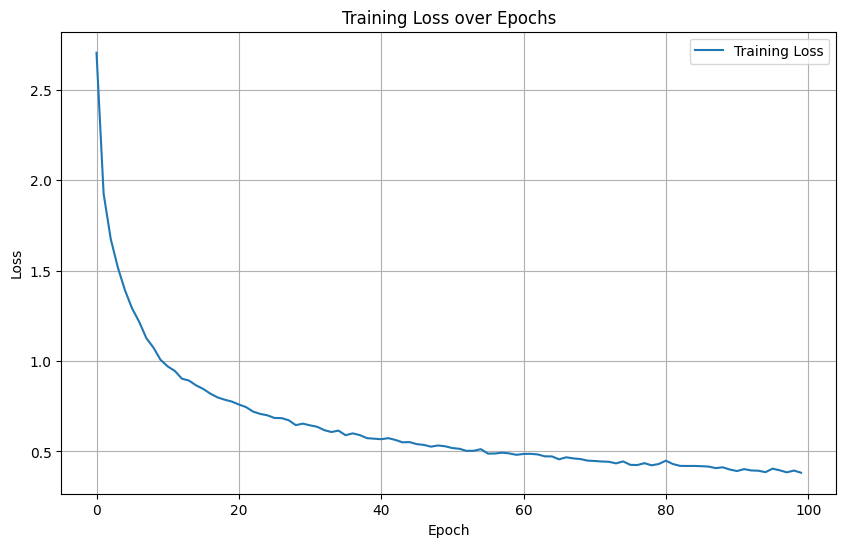

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

----

In [20]:
def compute_similarity_scores(model, data_loader):
    similarities = []
    labels = []
    
    for (acc_batch, gyro_batch), batch_labels in data_loader:
        # get embeddings
        _, (e_accel, e_gyro) = model(acc_batch, gyro_batch, return_feat=True, training=False) 
        # get embedding of accel and gyro
        
        # calculate cosine similarity between paired embeddings
        batch_similarities = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
        
        similarities.extend(batch_similarities.numpy())
        labels.extend(batch_labels.numpy())
    
    return np.array(similarities), np.array(labels)

In [21]:
normal_similarities = []
for acc_batch, gyro_batch in tqdm(train_dataset, desc='Computing normal similarities'):
    # train set embedding -> similarity
    _, (e_accel, e_gyro) = model(acc_batch, gyro_batch, return_feat=True, training=False) # <- embedding
    sim = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
    normal_similarities.extend(sim.numpy())

test_similarities = []
test_pred_labels = []
for (acc_batch, gyro_batch), labels in tqdm(test_dataset, desc='Computing test similarities'):
    # test set embedding -> simiilarity
    _, (e_accel, e_gyro) = model(acc_batch, gyro_batch, return_feat=True, training=False) # <- embedding
    sim = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
    test_similarities.extend(sim.numpy())
    test_pred_labels.extend(labels.numpy())

Computing test similarities: 100%|██████████| 1445/1445 [00:33<00:00, 43.14it/s]


In [22]:
def calculate_similarities(model, test_dataset):
    normal_similarities = []
    fall_similarities = []
    
    for (acc_batch, gyro_batch), labels in test_dataset:
        _, (e_accel, e_gyro) = model(acc_batch, gyro_batch, return_feat=True, training=False)
        
        sim = tf.reduce_sum(tf.multiply(e_accel, e_gyro), axis=1)
        
        for sim_score, label in zip(sim.numpy(), labels.numpy()):
            if label == 0:  # normal
                normal_similarities.append(sim_score)
            else:  # fall
                fall_similarities.append(sim_score)
    
    return np.array(normal_similarities), np.array(fall_similarities)

normal_sims, fall_sims = calculate_similarities(model, test_dataset)

print("[ ADL data ]")
print(f"  Mean: {np.mean(normal_sims):.4f}")
print(f"  Std: {np.std(normal_sims):.4f}")
print(f"  Min: {np.min(normal_sims):.4f}")
print(f"  Max: {np.max(normal_sims):.4f}")
for i in range (20) :
    print ('ADL ind', i+1, ':', normal_sims[i])

print ()
print("[ FALL data ]")
print(f"  Mean: {np.mean(fall_sims):.4f}")
print(f"  Std: {np.std(fall_sims):.4f}")
print(f"  Min: {np.min(fall_sims):.4f}")
print(f"  Max: {np.max(fall_sims):.4f}")
for i in range (20) :
    print ('FALL ind', i+1, ':', fall_sims[i])

[ ADL data ]
  Mean: 0.8705
  Std: 0.0818
  Min: -0.1372
  Max: 0.9839
ADL ind 1 : 0.902412
ADL ind 2 : 0.89955604
ADL ind 3 : 0.94383204
ADL ind 4 : 0.8447995
ADL ind 5 : 0.90771884
ADL ind 6 : 0.9066687
ADL ind 7 : 0.9031764
ADL ind 8 : 0.9191232
ADL ind 9 : 0.9187581
ADL ind 10 : 0.9137523
ADL ind 11 : 0.8894911
ADL ind 12 : 0.88222754
ADL ind 13 : 0.9170001
ADL ind 14 : 0.94109
ADL ind 15 : 0.9323229
ADL ind 16 : 0.8923222
ADL ind 17 : 0.9395809
ADL ind 18 : 0.8703749
ADL ind 19 : 0.87564254
ADL ind 20 : 0.8843456

[ FALL data ]
  Mean: 0.8008
  Std: 0.1468
  Min: -0.4484
  Max: 0.9850
FALL ind 1 : 0.7593883
FALL ind 2 : 0.9622107
FALL ind 3 : 0.8603578
FALL ind 4 : 0.9247415
FALL ind 5 : 0.87954754
FALL ind 6 : 0.9540335
FALL ind 7 : 0.8496203
FALL ind 8 : 0.8663614
FALL ind 9 : 0.7663702
FALL ind 10 : 0.8399726
FALL ind 11 : 0.9098669
FALL ind 12 : 0.8230212
FALL ind 13 : 0.14906992
FALL ind 14 : 0.90039086
FALL ind 15 : 0.8959236
FALL ind 16 : 0.5857654
FALL ind 17 : 0.62692523


In [23]:
threshold = np.percentile(normal_similarities, 10)

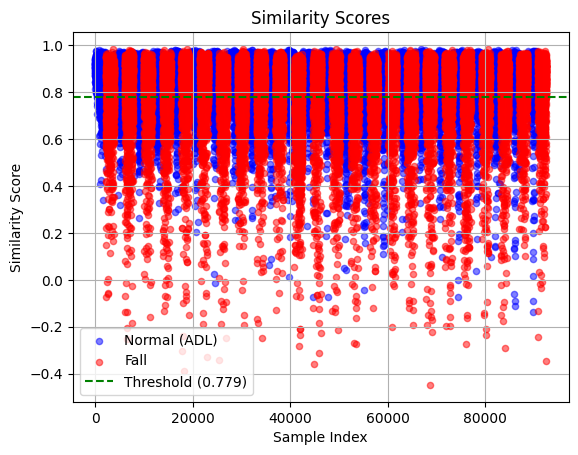

In [24]:
indices = range(len(test_similarities))
plt.scatter([i for i, l in zip(indices, test_pred_labels) if l == 0], 
           [s for s, l in zip(test_similarities, test_pred_labels) if l == 0],
           c='blue', label='Normal (ADL)', alpha=0.5, s=20)
plt.scatter([i for i, l in zip(indices, test_pred_labels) if l == 1],
           [s for s, l in zip(test_similarities, test_pred_labels) if l == 1],
           c='red', label='Fall', alpha=0.5, s=20)
plt.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold ({threshold:.3f})')
# plt.ylim(0.0078100, 0.0078150)
plt.xlabel('Sample Index')
plt.ylabel('Similarity Score')
plt.title('Similarity Scores')
plt.legend()
plt.grid(True)

In [25]:
predictions = [1 if sim < threshold else 0 for sim in test_similarities] 
true_labels = test_pred_labels

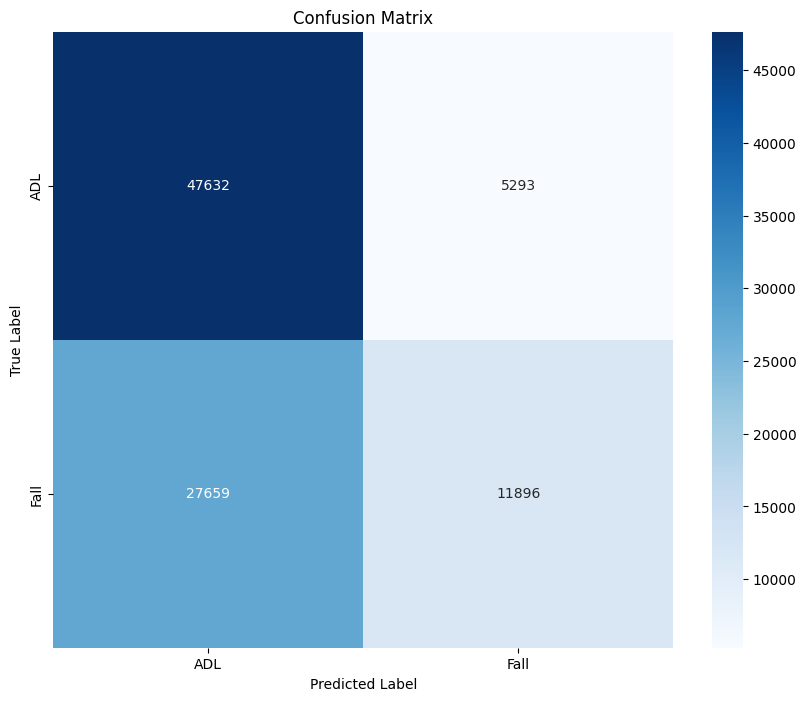

In [26]:
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
labels = ['ADL', 'Fall']
plt.xticks([0.5, 1.5], labels)
plt.yticks([0.5, 1.5], labels)
plt.show()

In [27]:
print ("classification report")
print(classification_report(true_labels, predictions, 
                          target_names=['ADL', 'Fall']))

classification report
              precision    recall  f1-score   support

         ADL       0.63      0.90      0.74     52925
        Fall       0.69      0.30      0.42     39555

    accuracy                           0.64     92480
   macro avg       0.66      0.60      0.58     92480
weighted avg       0.66      0.64      0.60     92480

